In [76]:
import numpy as np
import pandas as pd
import json

import matplotlib 
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV

import seaborn as sns


import time

plt.style.use('classic')
plt.style.use( 'seaborn-v0_8-white',)
sns.set_style("whitegrid", {'legend.frameon':True})

In [2]:
from dataclasses import dataclass


@dataclass
class OutputData:
    features: pd.DataFrame
    output: pd.DataFrame


def get_dataset(path: str):
    f = open(path)
    data = json.load(f)
    f.close()
    return data

In [93]:
# json_dataset = get_dataset('./datasets/linear/data_25_000.json') +\
#             get_dataset('./datasets/linear/data_30_000.json') +\
#             get_dataset('./datasets/linear/data_35_000.json') +\
#             get_dataset('./datasets/linear/data_50_000.json') +\
#             get_dataset('./datasets/linear/data_55_000.json') +\
#             get_dataset('./datasets/linear/data_150_000.json')   
json_dataset = get_dataset('./datasets/linear/data_10_000_32.json') +\
               get_dataset('./datasets/linear/data_40_000_32.json') +\
               get_dataset('./datasets/linear/data_15000_32.json') +\
               get_dataset('./datasets/linear/data_80000_32.json')
df = pd.json_normalize(json_dataset)

columns_rename = {
    ## service params
    'inp.services.cv': 'services_cv',
    'inp.services.skew': 'services_skew',
    'inp.services.rate_min': 'services_rate_min',
    'inp.services.rate_max': 'services_rate_max',
    ## arrival params
    'inp.arrival.skew': 'arrival_skew',
    'inp.arrival.cv': 'arrival_cv',
    'inp.arrival.rate': 'arrival_rate',
    ## num servers
    'inp.num_servers': 'num_servers',
    ## capacity
    'inp.capacity': 'capacity',
    ## meta info
    'meta.fitted.arrival_cv': 'meta_arrival_cv',
    'meta.fitted.arrival_skew': 'meta_arrival_skew',
    'meta.fitted.arrival_lag': 'meta_arrival_lag',
    'meta.fitted.arrival_cv': 'meta_arrival_cv',
    'meta.fitted.arrival_order': 'meta_arrival_order',
    'meta.fitted.service_cv': 'meta_service_cv',
    'meta.fitted.service_skew': 'meta_service_skew',
    'meta.fitted.service_order': 'meta_service_order',
    ## output
    'out.max_system_size.avg': 'out_max_system_size_avg',
    'out.max_system_size.std': 'out_max_system_size_std',
    'out.max_system_size.index': 'out_max_system_size_index',
    'out.min_system_size.avg': 'out_min_system_size_avg',
    'out.min_system_size.std': 'out_min_system_size_std',
    'out.min_system_size.index': 'out_min_system_size_index',
    'out.max_busy_rate.avg': 'out_max_busy_rate_avg',
    'out.max_busy_rate.std': 'out_max_busy_rate_std',
    'out.max_busy_rate.index': 'out_max_busy_rate_index',
    'out.min_busy_rate.avg': 'out_min_busy_rate_avg',
    'out.min_busy_rate.std': 'out_min_busy_rate_std',
    'out.min_busy_rate.index': 'out_min_busy_rate_index',
    'out.loss_prob': 'out_los_prob',
    'out.response_time.avg': 'out_response_time_avg',
    'out.response_time.std': 'out_response_time_std',
    'out.response_time.index': 'out_response_time_index'
}

df = df.rename(columns=columns_rename, inplace=False)
df = df.loc[df['out_response_time_avg'] < 20]
df = df.loc[df['meta_arrival_skew'] < 100]
df = df.loc[df['meta_service_skew'] < 100]

data = OutputData(
    features=df[[
                 'meta_service_skew', 
                 'meta_service_cv', 
                 'services_rate_min', 
                 'services_rate_max',
                 'meta_arrival_skew',
                 'meta_arrival_cv', 
                 'arrival_rate',
                 'num_servers',
                 'capacity'
    ]],
    output=df[['out_response_time_avg',
               'out_min_busy_rate_avg',
               'out_max_busy_rate_avg',
               'out_los_prob',
               'out_max_system_size_avg',
               'out_min_system_size_avg',
    ]]
)

## TODO remove input_type and lag from df
data

OutputData(features=        meta_service_skew  meta_service_cv services_rate_min  \
0                   61.20             2.86             29.55   
1                   79.69             4.98             32.00   
2                   12.60             2.84              5.98   
3                   78.71             1.48              9.20   
4                   76.80             3.68              2.73   
...                   ...              ...               ...   
144967              42.14             4.06              6.89   
144968              85.91             3.59             36.84   
144969              92.06             2.40              0.45   
144970               6.49             3.41             25.62   
144971              78.76             1.05              3.68   

       services_rate_max  meta_arrival_skew  meta_arrival_cv arrival_rate  \
0                  35.28              42.29             2.95        26.39   
1                  48.71              88.47             4

In [81]:
COLORS_MAP = {
    'green': ["Greens", 'lightgreen'],
    'blue': ["Blues", 'lightblue'],
    'orange': ["Oranges", "#fed8b1"],
    'purple': ['Purples', '#D8BFD8']
}


def build_estimates_tests_scatter(estimations, predictions,
                                  name="", 
                                  rang=[0, 10], 
                                  divider=1,
                                  xlabel='samples_s', 
                                  ylabel='sstimates_s',
                                  color='blue'):
    
    fig , ax = plt.subplots(figsize=(5, 5))
    cm = plt.get_cmap(COLORS_MAP.get(color)[0])
    col = [cm(1 / abs(predictions[i] - estimations[i])/divider) for i in range(len(estimations))]
    plt.scatter(predictions, estimations, c=col, marker='^', linewidth=0.2)
    x = np.linspace(rang[0], rang[1])
    plt.plot(x, x, linestyle='-', linewidth=2, color=COLORS_MAP.get(color)[1])
    plt.title('{}'.format(name), fontsize=22, pad=10)
    ax.title.set_fontsize(24)
    plt.xticks([i for i in range(0, rang[1], 2)])
    plt.tick_params(labelsize=22)
    plt.yticks([i for i in range(0, rang[1], 2)])

    plt.xlim(rang)
    plt.ylim(rang)

    ax.set_xlabel(xlabel, size=24)
    ax.set_ylabel(ylabel, size=24)

In [82]:
def corr(x: np.ndarray, y: np.ndarray) -> float:
    """
    Correlation coefficient between simulation model 
    values and estimate 
    """
    r = np.corrcoef(x, y)
    return r[0,1]

def regression_report(y_true, y_pred):
    return {
        "corr": corr(y_true, y_pred),
        "r2_score": r2_score(y_true, y_pred),
        "mse": mean_squared_error(y_true, y_pred)
    }

## response time regression

In [94]:
response_time = data.output['out_response_time_avg']
response_time

0          0.349017
1          0.169287
2          0.973574
3          0.490732
4          2.175073
            ...    
144967     0.845704
144968     0.480682
144969    17.318959
144970     0.466255
144971     0.459221
Name: out_response_time_avg, Length: 142372, dtype: float64

In [95]:
data.features

,meta_service_skew,meta_service_cv,services_rate_min,services_rate_max,meta_arrival_skew,meta_arrival_cv,arrival_rate,num_servers,capacity
0,61.20,2.86,29.55,35.28,42.29,2.95,26.39,4,14
1,79.69,4.98,32.00,48.71,88.47,4.85,31.05,4,5
2,12.60,2.84,5.98,44.92,96.78,1.66,22.23,11,4
3,78.71,1.48,9.20,19.00,51.46,3.20,2.43,20,16
4,76.80,3.68,2.73,48.25,62.84,3.83,5.96,18,5
...,...,...,...,...,...,...,...,...,...
144967,42.14,4.06,6.89,20.23,24.23,0.79,2.23,20,2
144968,85.91,3.59,36.84,38.17,26.71,1.28,9.14,32,8
144969,92.06,2.40,0.45,34.58,16.48,1.92,9.61,7,7
144970,6.49,3.41,25.62,44.85,93.76,3.96,21.37,5,9


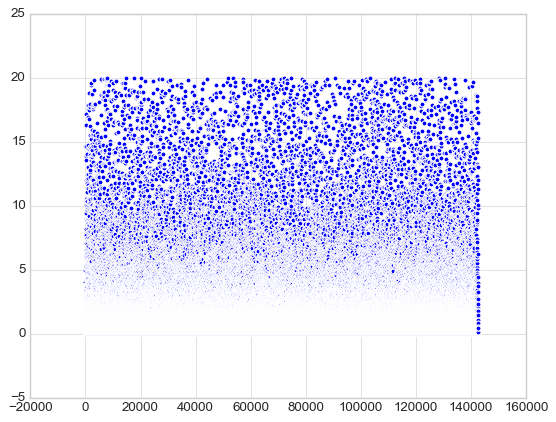

In [85]:
d = response_time
y = list(float(i) for i in d)
x = range(0, len(y))
plt.scatter(x, y)

## Prepare x_train and x_test

In [96]:
scaler = StandardScaler()
scaler.fit(data.features)
features = scaler.transform(data.features)

X_train, X_test, y_train, y_test = train_test_split(features, response_time, train_size=0.8)

## Regression tree

In [97]:
# decision tree regressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

tree_params = {
                'criterion': ['mse', 'mae'],
                'max_depth':[4,6,8,9,10,15,20]
}

gs = GridSearchCV(
    DecisionTreeRegressor(random_state=0),
    tree_params,
    verbose=1,
    cv=10,
    n_jobs=4
)

#regressor = DecisionTreeRegressor(random_state=0)
#cross_val_score(regressor, df, y_busy_services, cv=10)

#gs.fit(df, y_busy_services)

start_time = time.time()
tree = DecisionTreeRegressor(criterion='absolute_error', max_depth=12)
print("Time for calculation decision tree {}".format(time.time() - start_time))

tree.fit(X_train, y_train)
#print(regression_report(y_test, tree.predict(X_test)))

Time for calculation decision tree 6.985664367675781e-05


DecisionTreeRegressor(criterion='absolute_error', max_depth=12)

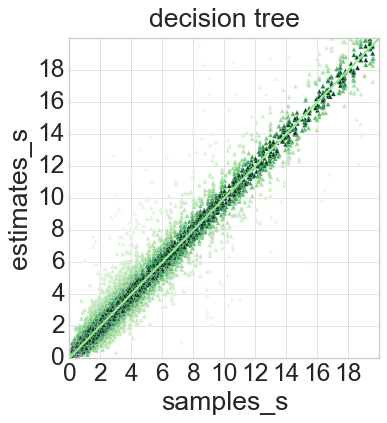

In [98]:
build_estimates_tests_scatter(
    y_test.values,
    tree.predict(X_test), 
    name="decision tree", 
    color="green",
    rang=[0, 20], divider=2, 
    xlabel="samples_s", 
    ylabel="estimates_s"
)

In [99]:
print(regression_report(y_test, tree.predict(X_test)))

{'corr': 0.9789338294439877, 'r2_score': 0.9581581453780382, 'mse': 0.2662928997329482}


## Gradient boosting

In [100]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

#grb_estimation_pipe = make_pipeline(StandardScaler(), GradientBoostingRegressor(max_depth=18, n_estimators=1000))

grb_estimation_pipe = GradientBoostingRegressor()

tree_params = {
    'loss': ['squared_error'],
    'criterion': ['squared_error'],
    'max_depth': [4, 6, 8, 12],
    'n_estimators': [600, 800, 1000]
}

start_time = time.time()
#grb_estimation_pipe.fit(X_train, y_train) 

gs = GridSearchCV(
    grb_estimation_pipe,
    param_grid=tree_params,
    n_jobs=6,
    cv=4
)


gs.fit(X_train, y_train)

print(gs.best_params_)
print(gs.best_score_)

#print("Time for calculation gradient boosting {}".format(time.time() - start_time))

{'criterion': 'squared_error', 'loss': 'squared_error', 'max_depth': 6, 'n_estimators': 1000}
0.9952480000470557


{'corr': 0.9976603503878874, 'r2_score': 0.99530986597751, 'mse': 0.029849283696173828}


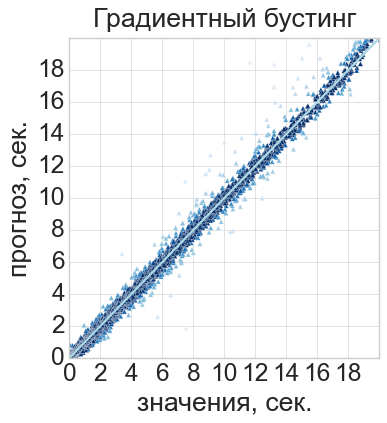

In [101]:
build_estimates_tests_scatter(
    y_test.values,
    gs.predict(X_test), 
    name="Градиентный бустинг", 
    color="blue",
    rang=[0, 20], divider=2, 
    xlabel="значения, сек.", 
    ylabel="прогноз, сек."
)
print(regression_report(y_test, gs.predict(X_test)))


## Neural network

In [102]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
import time

import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

class LinearRegressionNet(nn.Module):
    def __init__(self, features_count, outputs_count):
        super().__init__()
        self.linear1 = nn.Linear(features_count, 128)
        self.act1 = nn.LeakyReLU()
        self.batchnorm = nn.BatchNorm1d(128)
        self.linear2 = nn.Linear(128, outputs_count)
        self.act2 = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.batchnorm(x)
        x = self.linear2(x)
        x = self.act2(x)
        return x

loss_fn = F.mse_loss
inputs = torch.from_numpy(X_train).type(torch.float32)
targets = torch.from_numpy(y_train.to_numpy()).type(torch.float32)
targets = targets.reshape((targets.size(0), 1))

train_ds = TensorDataset(inputs, targets)

batch_size = 4096
train_dl = DataLoader(train_ds, batch_size, shuffle=False)
rt_model = LinearRegressionNet(inputs.shape[1], 1)
opt = torch.optim.Adam(rt_model.parameters(), lr=0.001)

losses = []
def fit(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward() 
            opt.step()
            opt.zero_grad()
        losses.append(loss_fn(model(xb), yb).detach().flatten()[0])    
        if epoch % 100 == 0:    
            print('Epoch {}: Training loss: {}'.format(epoch, loss_fn(model(xb), yb)))    
    print('Training loss: ', loss_fn(model(inputs), targets))

# learning model

start_time = time.time()
rt_model.train()
fit(1000, rt_model, loss_fn, opt)
print("Time for calculation learing neural network {}".format(time.time() - start_time))

torch.no_grad()
rt_model.eval()

cpu
Epoch 0: Training loss: 4.748908042907715
Epoch 100: Training loss: 0.06636527925729752
Epoch 200: Training loss: 0.05119071155786514
Epoch 300: Training loss: 0.046993616968393326
Epoch 400: Training loss: 0.04775729030370712
Epoch 500: Training loss: 0.048671990633010864
Epoch 600: Training loss: 0.04221120476722717
Epoch 700: Training loss: 0.039819251745939255
Epoch 800: Training loss: 0.03590485453605652
Epoch 900: Training loss: 0.036086250096559525
Training loss:  tensor(0.0402, grad_fn=<MseLossBackward0>)
Time for calculation learing neural network 1420.8162229061127


LinearRegressionNet(
  (linear1): Linear(in_features=9, out_features=128, bias=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=128, out_features=1, bias=True)
  (act2): ReLU()
)

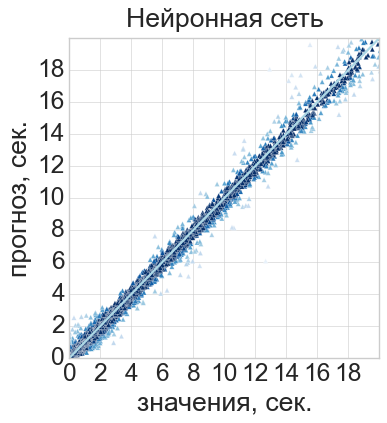

In [103]:
build_estimates_tests_scatter(y_test.to_numpy().flatten(), 
                              rt_model(torch.from_numpy(X_test).type(torch.float32)).detach().numpy().flatten(),
                              name="Нейронная сеть",
                              xlabel="значения, сек.", 
                              ylabel="прогноз, сек.",
                              rang=[0, 20], divider=2)

In [104]:
regression_report(y_test.to_numpy().flatten(), rt_model(torch.from_numpy(X_test).type(torch.float32)).detach().numpy().flatten())

{'corr': 0.9972554990972889,
 'r2_score': 0.9942344254881,
 'mse': 0.03746156796561931}

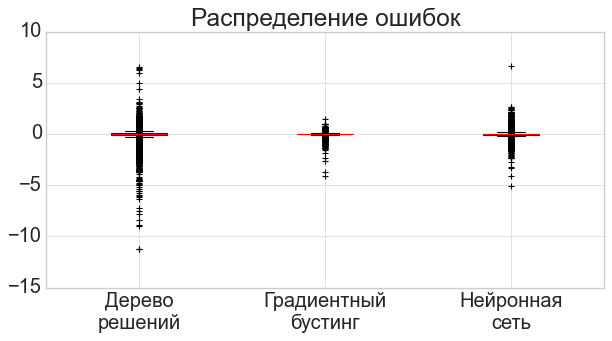

In [209]:
all_data = [
    tree.predict(X_test).flatten() - y_test.to_numpy(),
    gs.predict(X_test).flatten() - y_test.to_numpy(),
    rt_model(torch.from_numpy(X_test).type(torch.float32)).detach().numpy().flatten() - y_test
]

fig, ax = plt.subplots(figsize=(9, 4))
labels = ["Дерево\nрешений", "Градиентный\nбустинг", "Нейронная\nсеть"]
# rectangular box plot
bplot = ax.boxplot(all_data,
                    vert=True,  # vertical box alignment
                    patch_artist=True,  # fill with color
                    labels=labels)  # will be used to label x-ticks
ax.set_title("Распределение ошибок", fontsize=22)
ax.tick_params(labelsize=18)
fig.savefig('resp_errors.png',  bbox_inches="tight")

/var/folders/51/xsy_132d0qn6cs7kbh37ynf40000gn/T/ipykernel_22376/433784619.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  col = [cm(1 / abs(predictions[i] - estimations[i])/divider) for i in range(len(estimations))]


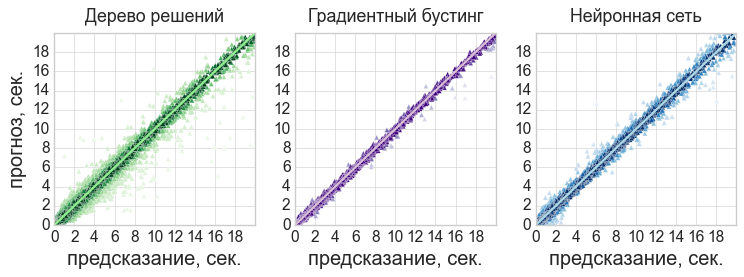

In [211]:
def build_estimates_tests_scatter_all():
    
    fig , (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 3))

    def render_plot(
        ax, 
        predictions,
        estimations,
        name="", 
        rang=[0, 20], 
        color='red',
        divider=1,
    ):
        cm = plt.get_cmap(COLORS_MAP.get(color)[0])
        col = [cm(1 / abs(predictions[i] - estimations[i])/divider) for i in range(len(estimations))]
        ax.scatter(predictions, estimations, c=col, marker='^', linewidth=0.2)
        x = np.linspace(rang[0], rang[1])
        ax.plot(x, x, linestyle='-', linewidth=2, color=COLORS_MAP.get(color)[1])
        ax.set_title('{}'.format(name), fontsize=16, pad=10)
        ax.set_xticks([i for i in range(0, rang[1], 2)])
        ax.set_xticklabels([i for i in range(0, rang[1], 2)], fontsize=14)
        #ax.set_tick_params(labelsize=22)
        ax.set_yticks([i for i in range(0, rang[1], 2)])
        ax.set_yticklabels([i for i in range(0, rang[1], 2)], fontsize=14)


        ax.set_xlim(rang)
        ax.set_ylim(rang)

        ax.set_xlabel("предсказание, сек.", size=18)
        if name == 'Дерево решений':
            ax.set_ylabel("прогноз, сек.", size=18)

    render_plot(
        ax1, 
        y_test.values,
        tree.predict(X_test), 
        name="Дерево решений", 
        color="green",
        rang=[0, 20], 
        divider=2
    )
    render_plot(
        ax2, 
        y_test.values,
        gs.predict(X_test), 
        name="Градиентный бустинг", 
        color="purple",
        rang=[0, 20], 
        divider=2
    )
    render_plot(
        ax3, 
        y_test.values,
        rt_model(torch.from_numpy(X_test).type(torch.float32)).detach().numpy().flatten(),
        name="Нейронная сеть", 
        color="blue",
        rang=[0, 20], 
        divider=2
    )
    fig.savefig('resp_scatter.png',  bbox_inches="tight")
    
build_estimates_tests_scatter_all()

## Validation

In [108]:
# json_dataset = get_dataset('./datasets/linear/data_25_000.json') +\
#             get_dataset('./datasets/linear/data_30_000.json') +\
#             get_dataset('./datasets/linear/data_35_000.json') +\
#             get_dataset('./datasets/linear/data_50_000.json') +\
#             get_dataset('./datasets/linear/data_55_000.json') +\
#             get_dataset('./datasets/linear/data_150_000.json')   
def get_dataset_results(paths):
    json_dataset = []
    for path in paths:
        json_dataset += get_dataset(path)

    df = pd.json_normalize(json_dataset)

    columns_rename = {
        ## service params
        'inp.services.cv': 'services_cv',
        'inp.services.skew': 'services_skew',
        'inp.services.rate_min': 'services_rate_min',
        'inp.services.rate_max': 'services_rate_max',
        ## arrival params
        'inp.arrival.skew': 'arrival_skew',
        'inp.arrival.cv': 'arrival_cv',
        'inp.arrival.rate': 'arrival_rate',
        ## num servers
        'inp.num_servers': 'num_servers',
        ## capacity
        'inp.capacity': 'capacity',
        ## meta info
        'meta.fitted.arrival_cv': 'meta_arrival_cv',
        'meta.fitted.arrival_skew': 'meta_arrival_skew',
        'meta.fitted.arrival_lag': 'meta_arrival_lag',
        'meta.fitted.arrival_cv': 'meta_arrival_cv',
        'meta.fitted.arrival_order': 'meta_arrival_order',
        'meta.fitted.service_cv': 'meta_service_cv',
        'meta.fitted.service_skew': 'meta_service_skew',
        'meta.fitted.service_order': 'meta_service_order',
        ## output
        'out.max_system_size.avg': 'out_max_system_size_avg',
        'out.max_system_size.std': 'out_max_system_size_std',
        'out.max_system_size.index': 'out_max_system_size_index',
        'out.min_system_size.avg': 'out_min_system_size_avg',
        'out.min_system_size.std': 'out_min_system_size_std',
        'out.min_system_size.index': 'out_min_system_size_index',
        'out.max_busy_rate.avg': 'out_max_busy_rate_avg',
        'out.max_busy_rate.std': 'out_max_busy_rate_std',
        'out.max_busy_rate.index': 'out_max_busy_rate_index',
        'out.min_busy_rate.avg': 'out_min_busy_rate_avg',
        'out.min_busy_rate.std': 'out_min_busy_rate_std',
        'out.min_busy_rate.index': 'out_min_busy_rate_index',
        'out.loss_prob': 'out_los_prob',
        'out.response_time.avg': 'out_response_time_avg',
        'out.response_time.std': 'out_response_time_std',
        'out.response_time.index': 'out_response_time_index'
    }

    df = df.rename(columns=columns_rename, inplace=False)
    df = df.loc[df['out_response_time_avg'] < 20]
    df = df.loc[df['meta_arrival_skew'] < 100]
    df = df.loc[df['meta_service_skew'] < 100]

    data = OutputData(
        features=df[[
                 'meta_service_skew', 
                 'meta_service_cv', 
                 'services_rate_min', 
                 'services_rate_max',
                 'meta_arrival_skew',
                 'meta_arrival_cv', 
                 'arrival_rate',
                 'num_servers',
                 'capacity'
        ]],
        output=df[['out_response_time_avg',
               'out_min_busy_rate_avg',
               'out_max_busy_rate_avg',
               'out_los_prob',
               'out_max_system_size_avg',
               'out_min_system_size_avg',
        ]]
    )

    return data

In [126]:
def build_validation_response_time_chart(
        data, 
        #tree_data, 
        boosting_data, 
        neural_network_data, 
        x_label, 
        title="", 
        range_=range(1, 11)
    ):
    
    plt.figure(figsize=(10, 5))
    
    sns.set_palette("Set1", 10)
    #plt.plot(range_, tree_data, label="decision tree", color="green")
    plt.plot(range_, data, 'o', label="simulation", linewidth=4, linestyle="dashed")
    plt.plot(range_, boosting_data, label="gradient boosting", linestyle="dotted", linewidth=4, marker="X")
    plt.plot(range_, neural_network_data, label="neural network", linewidth=4, marker="x")
    
    #plt.ylabel('response time, s', fontsize=24)
    plt.xlabel(x_label, fontsize=26)
    plt.ylabel('response time', fontsize=26)
    plt.tick_params(labelsize=24)

    plt.legend(prop={'size': 24}, fontsize=48, edgecolor="grey", facecolor="white", frameon=False)

### by arrival intecity

0.0017390251159667969
0.0003032684326171875
0.0012407302856445312


ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

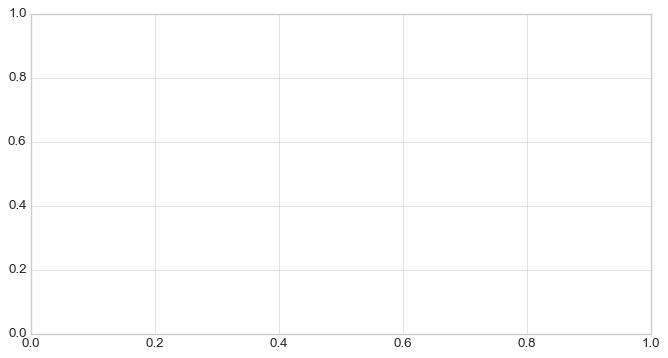

In [214]:
import time

by_arrival_intecity = get_dataset_results(['./datasets/linear/validation/arrival_res.json'])
scaled_features = scaler.transform(by_arrival_intecity.features)

current_time = time.time()
nn_results = rt_model(torch.from_numpy(scaled_features).type(torch.float32)).detach().numpy().flatten()
print(time.time() - current_time)
current_time = time.time()
tree.predict(scaled_features)
print(time.time() - current_time)
current_time = time.time()
gs.predict(scaled_features)
print(time.time() - current_time)

nn_results, by_arrival_intecity.output['out_response_time_avg'], gs.predict(scaled_features)
build_validation_response_time_chart(
    by_arrival_intecity.output['out_response_time_avg'],
    gs.predict(scaled_features),
    nn_results,
    'arrival lambda',
    range_=range(5, 51, 5)
)

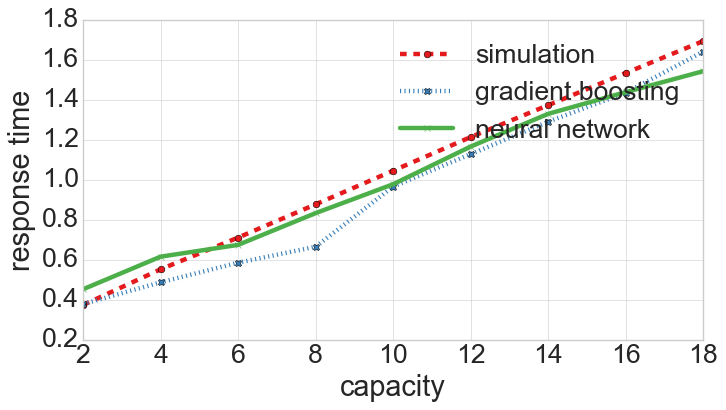

In [135]:
by_capacity = get_dataset_results(['./datasets/linear/validation/capacity_res.json'])
scaled_features = scaler.transform(by_capacity.features)
nn_results = rt_model(torch.from_numpy(scaled_features).type(torch.float32)).detach().numpy().flatten()
nn_results, by_arrival_intecity.output['out_response_time_avg'], gs.predict(scaled_features)
build_validation_response_time_chart(
    by_capacity.output['out_response_time_avg'],
    gs.predict(scaled_features),
    nn_results,
    'capacity',
    range_=range(2, 20, 2)
)

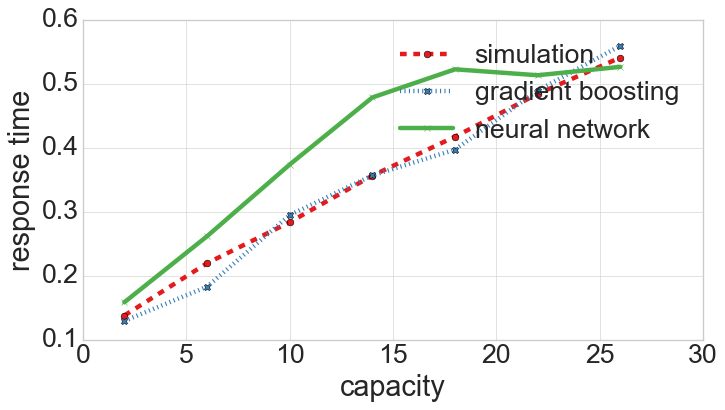

In [138]:
by_servers = get_dataset_results(['./datasets/linear/validation/servers_res.json'])
scaled_features = scaler.transform(by_servers.features)
nn_results = rt_model(torch.from_numpy(scaled_features).type(torch.float32)).detach().numpy().flatten()
nn_results, by_arrival_intecity.output['out_response_time_avg'], gs.predict(scaled_features)
build_validation_response_time_chart(
    by_servers.output['out_response_time_avg'],
    gs.predict(scaled_features),
    nn_results,
    'capacity',
    range_=range(2, 30, 4)
)

/var/folders/51/xsy_132d0qn6cs7kbh37ynf40000gn/T/ipykernel_22376/4114019512.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(range_, data, 'o', label="Монте-Карло", linewidth=4, linestyle="dashed", marker="X")
/var/folders/51/xsy_132d0qn6cs7kbh37ynf40000gn/T/ipykernel_22376/4114019512.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(range_, data, 'o', label="Монте-Карло", linewidth=4, linestyle="dashed", marker="X")
/var/folders/51/xsy_132d0qn6cs7kbh37ynf40000gn/T/ipykernel_22376/4114019512.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(range_, data, 'o', label="Монте-Карло", linewidth=4, linestyle="dashed", m

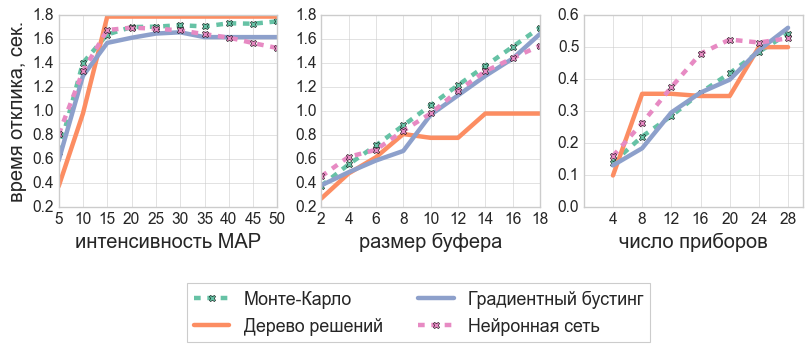

In [205]:
def build_validation_common():
    fig , (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
    sns.set_palette("Set2", 10)
    
    def build_single_chart(
        ax,
        data, 
        tree_data, 
        boosting_data, 
        neural_network_data, 
        x_label, 
        title="", 
        range_=range(1, 11)
    ):
        ax.plot(range_, data, 'o', label="Монте-Карло", linewidth=4, linestyle="dashed", marker="X")
        ax.plot(range_, tree_data, label="Дерево решений", linewidth=4)
        ax.plot(range_, boosting_data, label="Градиентный бустинг", linewidth=4)
        ax.plot(range_, neural_network_data, label="Нейронная сеть", linestyle="dashed", linewidth=4, marker="X")

        
        #plt.ylabel('response time, s', fontsize=24)
        ax.set_xlabel(x_label, fontsize=18)
        if x_label == 'интенсивность MAP':
            ax.set_ylabel('время отклика, сек.', fontsize=18)
            fig.legend(*ax.get_legend_handles_labels(), loc='lower center', 
                   bbox_to_anchor=(0.5, -0.5), ncol=2, fontsize=16, frameon=True)
        ax.set_xticks([i for i in range_])
        ax.set_xticklabels([i for i in range_], fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=14)



    by_arrival_intecity = get_dataset_results(['./datasets/linear/validation/arrival_res.json'])
    scaled_features = scaler.transform(by_arrival_intecity.features)
    nn_results = rt_model(torch.from_numpy(scaled_features).type(torch.float32)).detach().numpy().flatten()
    nn_results, by_arrival_intecity.output['out_response_time_avg'], gs.predict(scaled_features)
    
    build_single_chart(
        ax1,
        by_arrival_intecity.output['out_response_time_avg'],
        tree.predict(scaled_features),
        gs.predict(scaled_features),
        nn_results,
        'интенсивность MAP',
        range_=range(5, 51, 5)    
    )

    by_capacity = get_dataset_results(['./datasets/linear/validation/capacity_res.json'])
    scaled_features = scaler.transform(by_capacity.features)
    nn_results = rt_model(torch.from_numpy(scaled_features).type(torch.float32)).detach().numpy().flatten()
    nn_results, by_arrival_intecity.output['out_response_time_avg'], gs.predict(scaled_features)

    build_single_chart(
        ax2,
        by_capacity.output['out_response_time_avg'],
        tree.predict(scaled_features),
        gs.predict(scaled_features),
        nn_results,
        'размер буфера',
        range_=range(2, 20, 2)   
    )

    by_servers = get_dataset_results(['./datasets/linear/validation/servers_res.json'])
    scaled_features = scaler.transform(by_servers.features)
    nn_results = rt_model(torch.from_numpy(scaled_features).type(torch.float32)).detach().numpy().flatten()
    nn_results, by_arrival_intecity.output['out_response_time_avg'], gs.predict(scaled_features)

    build_single_chart(
        ax3,
        by_servers.output['out_response_time_avg'],
        tree.predict(scaled_features),
        gs.predict(scaled_features),
        nn_results,
        'число приборов',
        range_=range(4, 30, 4)  
    )
    fig.savefig('resp_validation.png',  bbox_inches="tight")

build_validation_common()